In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from skimage.morphology import skeletonize
import skimage.morphology as morph
import skimage.measure as measure
from scipy import ndimage
% matplotlib inline

(0, 1023)

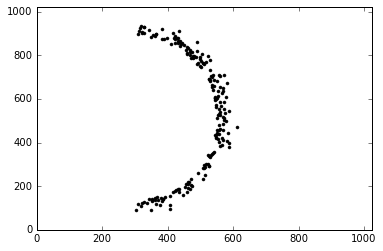

In [53]:
r = 250 + 20*np.abs(np.random.randn(200,1))
theta = np.random.randint(-90,90,size=(200,1))

xp = 300 + r*np.cos(np.deg2rad(theta))
yp = 512 + 1.5*r*np.sin(np.deg2rad(theta))

plt.plot(xp,yp,'k.')
plt.xlim(0,1023)
plt.ylim(0,1023)

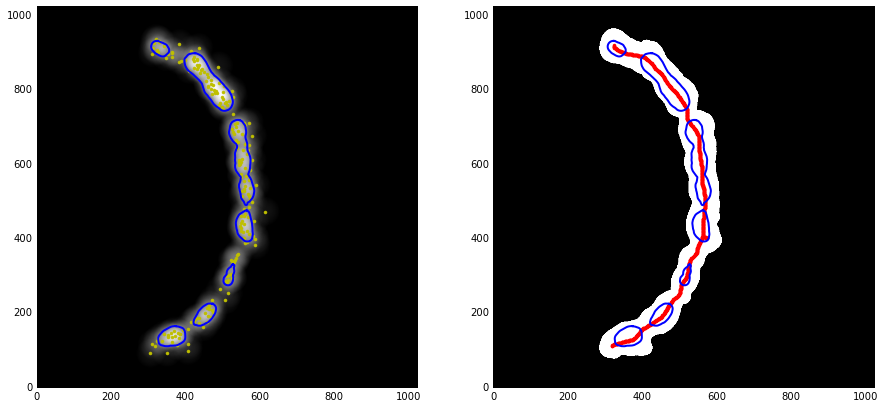

In [54]:
# Estimate the distribution
x = np.arange(0, 1024)
y = np.arange(0, 1024)
xm, ym = np.meshgrid(x, y)
all_coords = np.vstack([xm.ravel(), ym.ravel()]).T

# Parse classification cloud to kernel density estimator. Returns log of density.
xy = np.hstack([xp, yp])
kernel = "epanechnikov"
bandwidth = 40
thresh = 10
kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(xy)
log_pdf = np.reshape(kde.score_samples(all_coords), xm.shape)
# Convert the pdf to a binary map of where the distribution is > np.max(dist)/thresh
pdf = np.exp(log_pdf.copy())
thresh = np.max(pdf) / thresh
pdf_binary = pdf.copy()
pdf_binary[pdf_binary < thresh] = 0
pdf_binary[pdf_binary >= thresh] = 1

# Only keep the largest CME feature in the binary map.
# Label each binary blob
pdf_binary_label = measure.label(pdf_binary.astype(int))
# update label so that the background pixels have the same label of zero
pdf_binary_label[pdf_binary == 0] = 0
# Find how many unique labels and how many pixels in each label
lab, cnt = np.unique(pdf_binary_label, return_counts=True)
# Sort these so largest is last in list.
# Largest should always be the background. So keep two largest - background and clearest CME identification
lab = lab[np.argsort(cnt)]
for l in lab[:-2]:
    pdf_binary_label[pdf_binary_label == l] = 0

    # Set the largest blob back to 1 rather than it's label.
pdf_binary_label[pdf_binary_label != 0] = 1
# Use scikit-image skeletonize to get skeleton of the binary map, get pixel coordinates and output to dataframe
skel = skeletonize(pdf_binary_label)
skelcoords = np.nonzero(skel)

contours = measure.find_contours(pdf, np.max(pdf)/2)
fig, ax = plt.subplots(1,2, figsize=(15,10))
ax[0].imshow(pdf, cmap='gray')
ax[0].plot(xp, yp, 'y.')
ax[1].imshow(pdf_binary, cmap='gray')
ax[1].plot(skelcoords[1], skelcoords[0], 'r.')
for n, contour in enumerate(contours):
    ax[0].plot(contour[:, 1], contour[:, 0], 'b-', linewidth=2)
    ax[1].plot(contour[:, 1], contour[:, 0], 'b-', linewidth=2)

for a in ax:
    a.set_xlim(0,1023)
    a.set_ylim(0,1023)

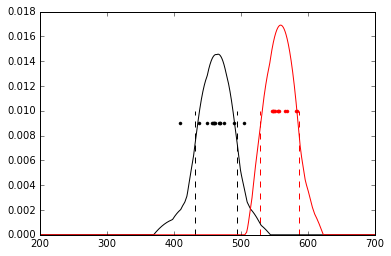

In [59]:
x1 = xp[(yp>800) & (yp<850)].reshape(-1,1)
x2 = xp[(yp>400) & (yp<450)].reshape(-1,1)
xd = np.arange(200,700,0.1).reshape(-1,1)

# Do KS density fit on all pixels.
# Transform to HPR.
#

# Make Diff images with T-E profiels overlaid
# Make Kinematics plots with New SSW and J-map T-E Profiles

def fit_kde(x_fit,x_dum):
    kernel = "epanechnikov"
    bandwidth = 40
    thresh = 10
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(x_fit)
    log_pdf = kde.score_samples(x_dum)
    pdf = np.exp(log_pdf.copy())
    return pdf

pdf1 = fit_kde(x1, xd)
pdf2 = fit_kde(x2, xd)

def get_fwhm(x, pdf):
    #Calc FWHM

    pdf_max = pdf.max()
    pdf_hm = pdf_max/2.0
    x_max = x[pdf == pdf_max]

    # Look low.
    pdf_l = pdf[x<x_max]
    x_l = x[x<x_max]
    x_hm_l = x_l[np.argmin(np.abs(pdf_l - pdf_hm))]

    # Look high.
    pdf_h = pdf[x>x_max]
    x_h = x[x>x_max]
    x_hm_h = x_h[np.argmin(np.abs(pdf_h - pdf_hm))]
    return x_hm_l, x_hm_h

x1_l, x1_h = get_fwhm(xd.ravel(), pdf1.ravel())
x2_l, x2_h = get_fwhm(xd.ravel(), pdf2.ravel())

fig, ax = plt.subplots()
ax.plot(xd,pdf1,'k-')
ax.plot(x1,np.zeros(x1.shape)+0.009,'k.')
ax.vlines(x1_l, 0, 0.01, linestyle='--', color='k')
ax.vlines(x1_h, 0, 0.01, linestyle='--', color='k')

ax.plot(xd,pdf2,'r-')
ax.plot(x2,np.zeros(x2.shape)+0.01,'r.')
ax.vlines(x2_l, 0, 0.01, linestyle='--', color='r')
ax.vlines(x2_h, 0, 0.01, linestyle='--', color='r')

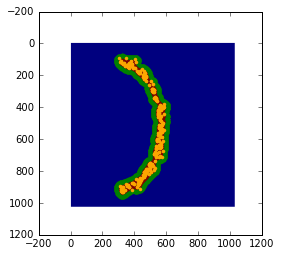

In [84]:
edge = measure.find_contours(pdf_binary,0.0)[0]
edge = np.fliplr(edge)
in_blob = measure.points_in_poly(xy, edge)

plt.imshow(pdf_binary)
plt.plot(xy[:,0],xy[:,1],'y.')
plt.plot(edge[:,0],edge[:,1],'g.')
xy_in = xy[in_blob]
plt.plot(xy_in[:,0],xy_in[:,1],'.', color='orange')